In [224]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%config Inlinebackground.figureFormat='retina'
sns.set(font_scale=1.75)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [225]:
# loading the datasets from text files
# cab data
cab_data = pd.read_csv(r'uber-lyft-cab-prices/Cab-Weather Data/Cab-Weather Data/cab_rides.txt', encoding='utf-16')
# weather data
weather_data = pd.read_csv(r'uber-lyft-cab-prices/Cab-Weather Data/Cab-Weather Data/weather.txt', encoding='utf-16')

### Missing Value Treatment

#### Cab Dataset

In [226]:
rows, cols = cab_data.shape
print(f'Cab ride dataset contains {rows} rows and {cols} columns.')

Cab ride dataset contains 693071 rows and 10 columns.


In [227]:
missing  = cab_data.isnull().sum().sum()
percent = round(((missing/cab_data.shape[0]) * 100),2)
print(f'Cab dataset contains {missing} missing values, which is {percent} % of whole data.')

Cab dataset contains 55095 missing values, which is 7.95 % of whole data.


In [228]:
cab_data.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

The missing values are present in the price column. We can convert these rows into validation set or check for reasons for missing data. Let's see if the missing values have some pattern or they occur at random.

In [229]:
# Check on cab type
cab_data[cab_data['price'].isnull()]['cab_type'].value_counts() 

Uber    55095
Name: cab_type, dtype: int64

We can see that, the missing values are present only in the Uber data. Let's also check the car type and model.

In [230]:
cab_data[cab_data['cab_type']=='Uber'].name.value_counts()

Black SUV    55096
WAV          55096
UberXL       55096
Black        55095
Taxi         55095
UberX        55094
UberPool     55091
Name: name, dtype: int64

In [231]:
cab_data[cab_data['price'].isnull()]['name'].value_counts() # car model

Taxi    55095
Name: name, dtype: int64

We see that all missing values belong to cab type = Taxi, Uber official website has no mention of this model and the missing values are less than 10% of the original data, hence we have can drop the records containing missing values.

In [232]:
#dropping the records
cab_data = cab_data.dropna()
rows, cols = cab_data.shape
print(f'Now the dataset contains {rows} rows and {cols} columns.')

Now the dataset contains 637976 rows and 10 columns.


In [233]:
cab_data.isnull().sum().sum() # check for missing values

0

In [234]:
cab_data = cab_data.sample(n=100000) # needs to be reverted at the end
cab_data.head(3)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
617117,1.06,Lyft,1544897111384,Northeastern University,Back Bay,16.5,1.0,2aea81c7-b6a8-437b-9b50-3c8e9391c96a,lyft_lux,Lux Black
325179,2.62,Uber,1543855980799,Boston University,Theatre District,22.0,1.0,8df4a198-73ff-4275-9b5a-44b909c7c710,6c84fd89-3f11-4782-9b50-97c468b19529,Black
267462,1.07,Lyft,1543362143555,Northeastern University,Back Bay,3.0,1.0,e14caa51-44e2-442f-8b8c-8b76af43e83e,lyft_line,Shared


In [235]:
weather_data.head(3)

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07


**Weather dataset**

In [236]:
rows, cols = weather_data.shape
print(f'weather dataset contains {rows} rows and {cols} columns.')

weather dataset contains 6276 rows and 8 columns.


In [237]:
missing  = weather_data.isnull().sum().sum()
percentage = round(((missing/weather_data.shape[0]) * 100),3)
print(f'weather dataset contains {missing} missing values, which is {percentage} % of whole data.')

weather dataset contains 5382 missing values, which is 85.755 % of whole data.


In [238]:
weather_data.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

We observed that the 'rain' feature has 85.75 % of the data as missing. After checking the weather conditions for that duration we can infer that the missing values are due to unobserved input variable, hence we will impute the missing values with zero, which denotes no rain.

In [239]:
# let's impute the missing values in the 'rain' column with 0
weather_data['rain'].fillna(0, inplace=True)

In [240]:
weather_data.isnull().sum().sum() # check for missing values

0

## Atrribute information

**Dependent variables**:       

    Distance - distance between source and destination             
    Cab_type - Uber or Lyft                 
    Time_stamp - epoch time when data was queried              
    Destination - destination of the ride              
    Source - the starting point of the ride              
    Surge_multiplier - the multiplier by which price was increased, default 1              
    Id - unique identifier              
    Product_id - uber/lyft identifier for cab-type              
    Name - Visible type of the cab eg: Uber Pool, UberXL              

**Target variable**:               

    Price - price estimate for the ride in USD

### Feature category        
**Categorical**       
    - Cab type
    - Destination
    - Source
    - Product Id
    - Name
    - Id
    - Surge Multiplier
    
**Continuous**     
    - Distance
    - Time stamp
    - Price

# Exploratory Data Analysis

In [241]:
# let's impute the time to standard date time format
cab_data['time_stamp'] = pd.to_datetime(cab_data['time_stamp'], unit='ms')
cab_data['date'] = cab_data['time_stamp'].dt.date  # extract date
cab_data['hour'] = cab_data['time_stamp'].dt.hour  # extract hour

cab_data.drop('time_stamp', axis=1, inplace=True)  # drop time_stamp feature

# splitting the dataset for easy access
uber = cab_data[cab_data['cab_type']=='Uber']
lyft = cab_data[cab_data['cab_type']=='Lyft']

cab_data.head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
617117,1.06,Lyft,Northeastern University,Back Bay,16.5,1.0,2aea81c7-b6a8-437b-9b50-3c8e9391c96a,lyft_lux,Lux Black,2018-12-15,18
325179,2.62,Uber,Boston University,Theatre District,22.0,1.0,8df4a198-73ff-4275-9b5a-44b909c7c710,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03,16
267462,1.07,Lyft,Northeastern University,Back Bay,3.0,1.0,e14caa51-44e2-442f-8b8c-8b76af43e83e,lyft_line,Shared,2018-11-27,23


## Univariate analysis

### Continuous variables

**Distance , Price and Surge Multiplier**

In [242]:
# Uber and Lyft data indexes
all_data=cab_data['cab_type']!=0 
lyft_data=cab_data['cab_type']=='Lyft'
uber_data=cab_data['cab_type']=='Uber'

In [243]:
#function for describing each variable
def col_description(*args,ls):
    for x in args:
        a=cab_data[x].loc[:,ls].apply(lambda x : x.describe(),axis=0)
        print(a)
        print()

In [244]:
num_lst=['distance','price','surge_multiplier']
col_description(all_data,uber_data,lyft_data,ls=num_lst) # gives column description for each dataframe passed

            distance          price  surge_multiplier
count  100000.000000  100000.000000     100000.000000
mean        2.193546      16.591856          1.015043
std         1.137748       9.362537          0.095319
min         0.020000       2.500000          1.000000
25%         1.280000       9.000000          1.000000
50%         2.160000      13.500000          1.000000
75%         2.940000      22.500000          1.000000
max         7.620000      92.000000          3.000000

           distance         price  surge_multiplier
count  51867.000000  51867.000000           51867.0
mean       2.198074     15.874882               1.0
std        1.183971      8.609518               0.0
min        0.020000      4.500000               1.0
25%        1.300000      9.000000               1.0
50%        2.170000     12.500000               1.0
75%        2.850000     21.500000               1.0
max        7.620000     76.000000               1.0

           distance         price  surge_mul

In [245]:
cat_lst=['destination','source','name'] # dropped factor variables which were not useful
col_description(all_data,uber_data,lyft_data,ls=cat_lst) # gives column description for each dataframe passed

       destination              source       name
count       100000              100000     100000
unique          12                  12         12
top         Fenway  Financial District  Black SUV
freq          8445                8612       8770

       destination              source       name
count        51867               51867      51867
unique          12                  12          6
top         Fenway  Financial District  Black SUV
freq          4413                4424       8770

       destination              source   name
count        48133               48133  48133
unique          12                  12      6
top       Back Bay  Financial District    Lux
freq          4110                4188   8127



In [246]:
# function to perform basic EDA for input columns
def EDA_function(df):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.distplot(df[lyft_data], ax=ax1, kde=True)
    ax1.set_title('Distribution of '+df.name+' in Lyft', fontsize=20)
    sns.distplot(df[uber_data], ax=ax2)
    ax2.set_title('Distribution of '+df.name+' in Uber', fontsize=20)
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    sns.boxplot(df[lyft_data], ax=ax1)
    ax1.set_title('Boxplot for '+df.name+' in Lyft', fontsize=20)
    sns.boxplot(df[uber_data], ax=ax2)
    ax2.set_title('Boxplot for '+df.name+' in Uber', fontsize=20)
    return(1)

C:\Users\himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\himanshu\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


distance            1
price               1
surge_multiplier    1
dtype: int64

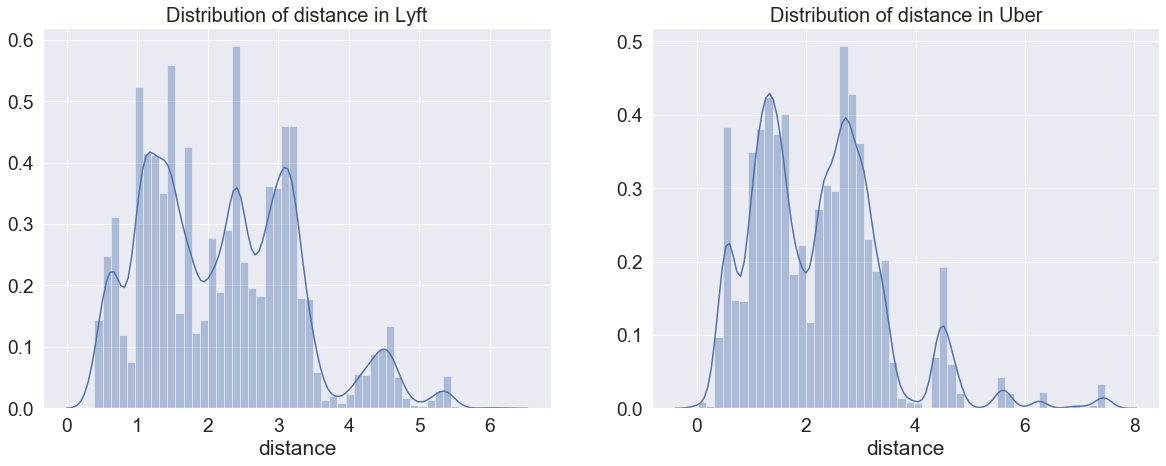

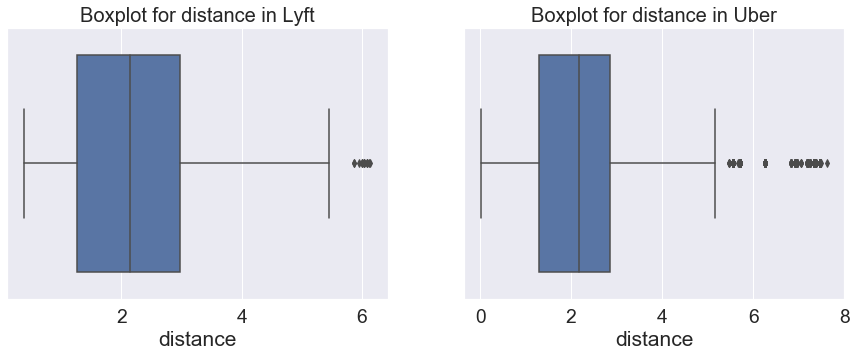

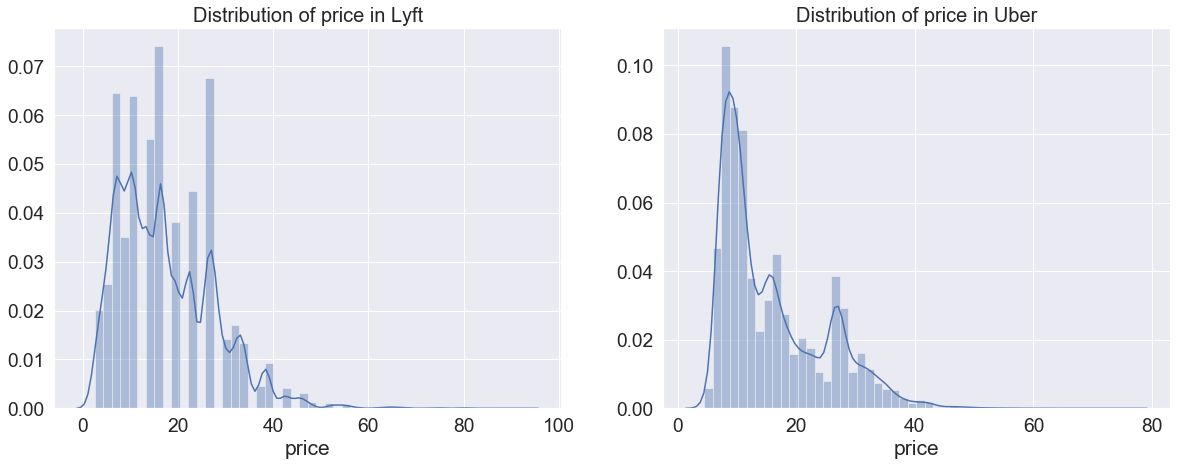

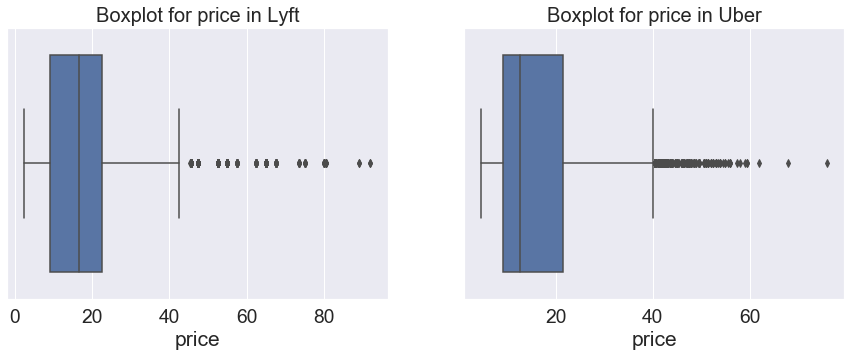

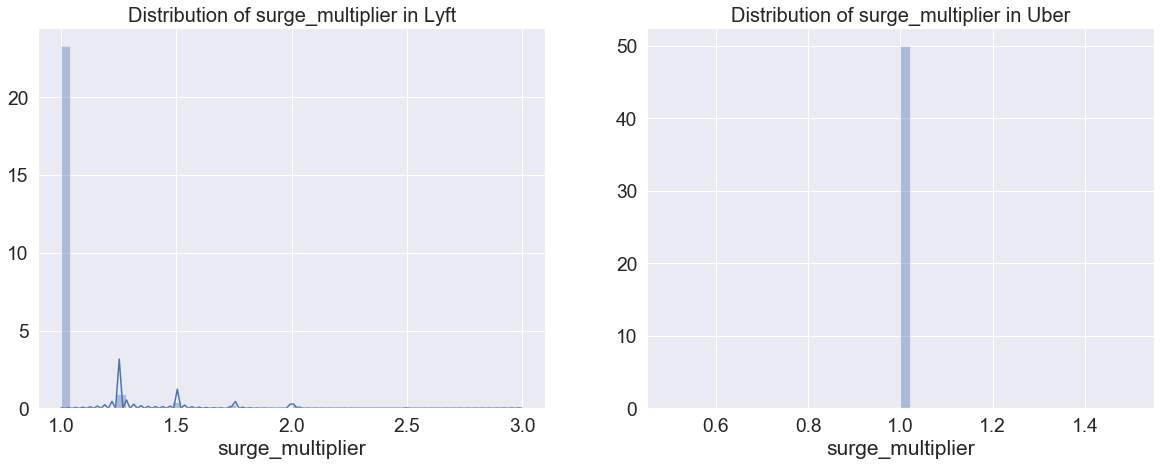

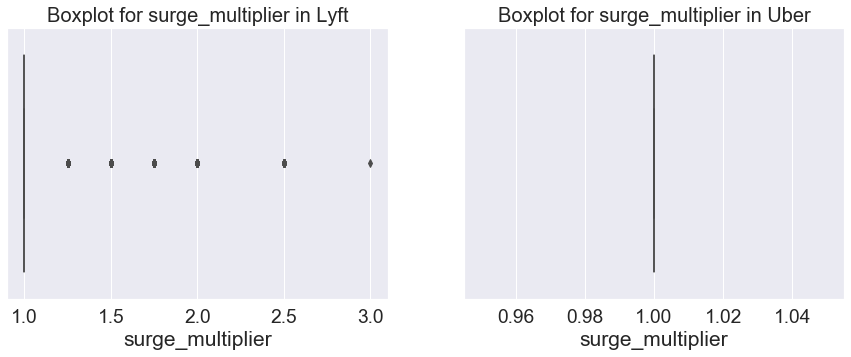

In [247]:
cab_data.loc[:,['distance','price','surge_multiplier']].apply(EDA_function,axis=0)
#cab_data.loc[:,['price']].apply(EDA_function,axis=0)

In [248]:
# Remove records below 0.25 as cancellation records
lyft[lyft['distance']<0.25] 

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour


In [249]:
uber[uber['distance']<0.25].sort_values(by='distance', ascending=False).head(30)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
275832,0.17,Uber,Theatre District,Boston University,7.0,1.0,53da08d9-ddae-4e1c-a772-fdeaf1b3c4d5,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-26,6
595398,0.17,Uber,Theatre District,Boston University,8.0,1.0,14c62c22-22ea-4472-919e-83665cbc5572,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26,6
165945,0.17,Uber,Theatre District,Boston University,8.0,1.0,29ca8abe-328b-47ad-bacb-a01c9a7df5e6,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26,6
275831,0.17,Uber,Theatre District,Boston University,27.0,1.0,13cb507f-dc20-45da-86ce-cf25aedd5106,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-26,6
275835,0.17,Uber,Theatre District,Boston University,4.5,1.0,7857e0d0-14eb-4c42-9099-9252e821f80d,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-26,6
564875,0.12,Uber,North End,West End,7.0,1.0,dbf534c2-be9b-4768-8770-5a7f617a5ad0,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-26,6
228457,0.12,Uber,North End,West End,8.5,1.0,344c7cd5-3ed4-4430-bc37-f8f5cd9e9159,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-26,6
219079,0.12,Uber,North End,West End,7.0,1.0,c1ce067a-7c76-4f09-b6f7-5266ecb6cde0,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26,7
582919,0.12,Uber,North End,West End,27.5,1.0,094b184d-1dc9-4a88-9cb5-34fc3b020f4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-26,6
228458,0.12,Uber,North End,West End,7.0,1.0,43c1a8d4-6fd2-4fdc-8c26-7a04355da105,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-26,6


In [250]:
cab_data=cab_data[cab_data['distance']>=0.25]
uber=uber[uber['distance']>=0.25]
lyft=lyft[lyft['distance']>=0.25] 

From the above graphs, we can see that most of the rides are in the range of approximately 0.5 to 5.5 miles. 
The distribution is slightly right skewed in the both Lyft and Uber.
Distance in Lyft is more evenly dispersed than Uber.

**Outliers**       
Both the data contains some outliers, this may be due to weather conditions in which riders may have to travel extra distance than usual or occassionally riders tend to travel long distances. Outliers couldalso be due to use of high-end cars and high surge multipliers. Therefore, we decided to keep them.

In [251]:
lyft[(lyft['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
21322,3.98,Lyft,Financial District,Northeastern University,45.5,1.75,e61682b5-3b85-4260-a6bf-1f5c4737062f,lyft_premier,Lux,2018-12-13,12
35835,3.98,Lyft,Financial District,Northeastern University,45.5,1.00,c093cb2e-500c-4f58-b99f-6eaf96be1f7d,lyft_luxsuv,Lux Black XL,2018-12-13,15
481434,5.36,Lyft,Boston University,Financial District,45.5,1.00,f976343a-4df4-4e26-9ee6-afffaf2edcdd,lyft_luxsuv,Lux Black XL,2018-12-03,2


In [252]:
uber[(uber['price']>40)].head(3)

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,date,hour
658758,2.32,Uber,Haymarket Square,Back Bay,49.5,1.0,ce927ade-de26-4efc-ae06-7ae4032a8521,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-14,23
671389,5.70,Uber,Boston University,Financial District,43.0,1.0,24cc6b2b-b96d-4151-9e43-395d82e914c5,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-26,11
179879,4.44,Uber,Boston University,Financial District,41.5,1.0,bc646126-6380-4643-80ca-e21d30536561,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-29,4


**Outliers handling**      
We could see that, some rides are higher priced than usual for different car models. From our analysis, we can conclude that duration of the trip also has an impact on the price, and we do not posses data regarding the duration of the trip, so we cannot remove these outliers.

The price distribution is right skewed, from the boxplot we could see the outliers present in the data. On average, the price range varies from 5 to 40 US dollars, Outliers exists due to factors such as use of luxury cars, high city traffic and bad weather conditions.

**Categorical variables**

**Cab type**

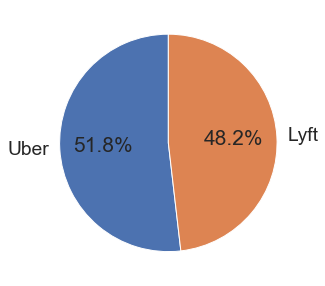

In [253]:
plt.figure(figsize=(8,5))

#Pie
Ncab_type = [cab_data.cab_type[(cab_data.cab_type)=='Uber'].count(),\
             cab_data.cab_type[(cab_data.cab_type)=='Lyft'].count()]
     
cab_type = ['Uber','Lyft']
plt.pie(Ncab_type, labels=cab_type, startangle=90, autopct='%.1f%%')
plt.show()

The dataset contains relatively higher proportion of Uber data, but we can say overall it is still balanced.

**Source, Destination and Name**

In [254]:
# function to perform basic EDA for input categorical variables
def EDA_cat_function(df):
    plt.figure(figsize=(8,5))
    sns.countplot(df[lyft_data])
    plt.title('Overall Frequency of '+df.name, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
    sns.countplot(df[lyft_data], ax=ax1)
    ax1.set_title('Frequency of '+df.name+' in Lyft', fontsize=20)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=15)
    
    sns.countplot(df[uber_data], ax=ax2)
    ax2.set_title('Frequency of '+df.name+' in Uber', fontsize=20)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=15)
    return(1)

From the charts below, we see that, there is a variety of surge mulipliers in Lyft, whereas in Uber, there is only one surge multiplier. This can be a possible reason for increased number of riders in Uber, compared to Lyft. From the frequency plot, we could see that almost all the car models are used in similar frequency.

destination    1
source         1
name           1
dtype: int64

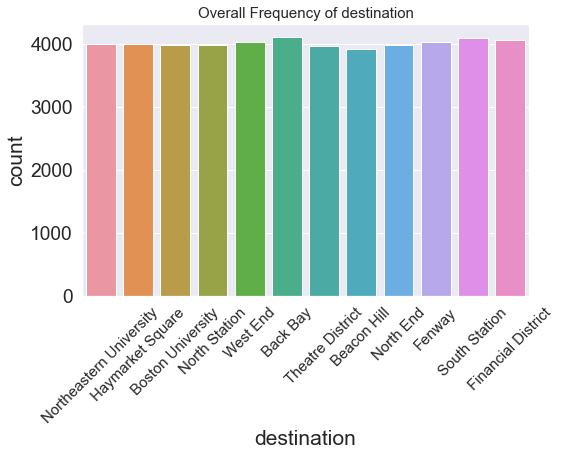

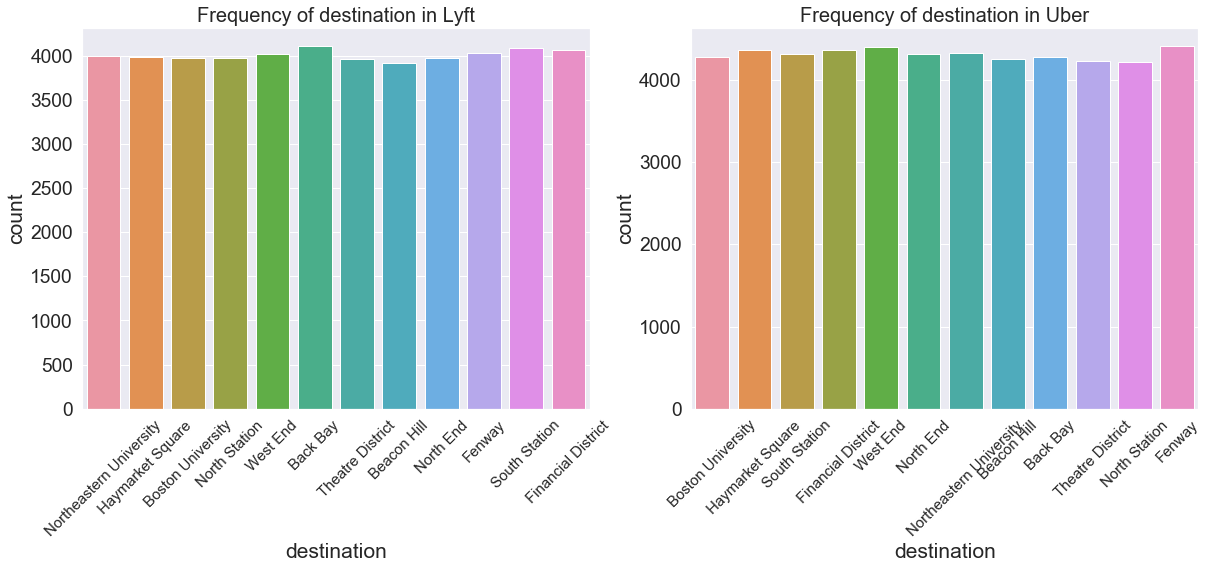

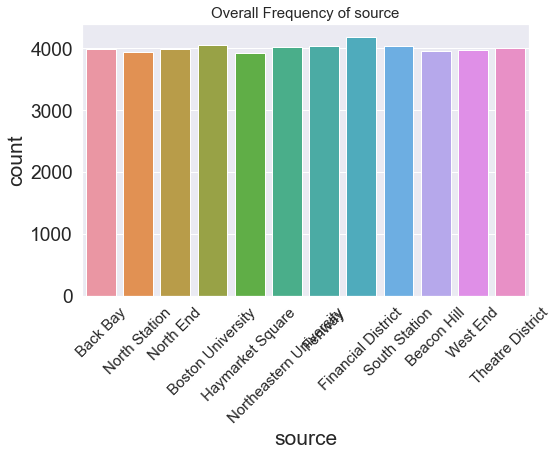

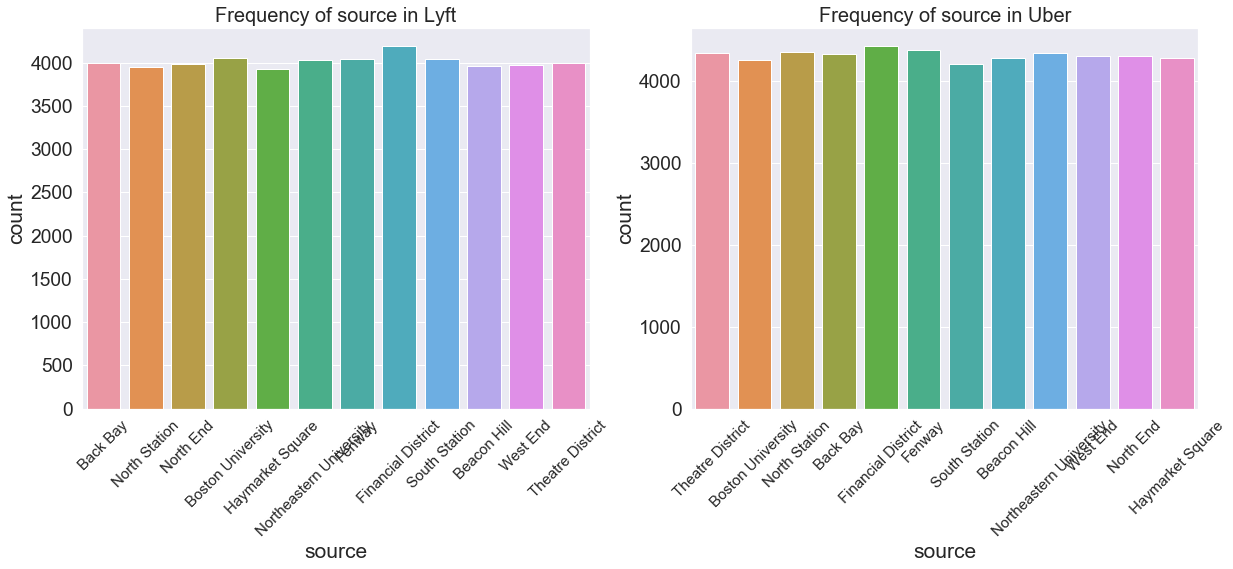

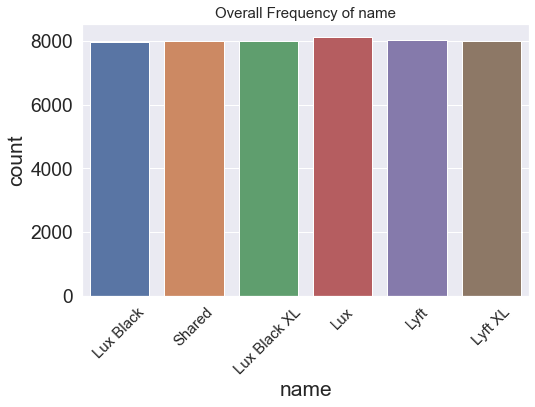

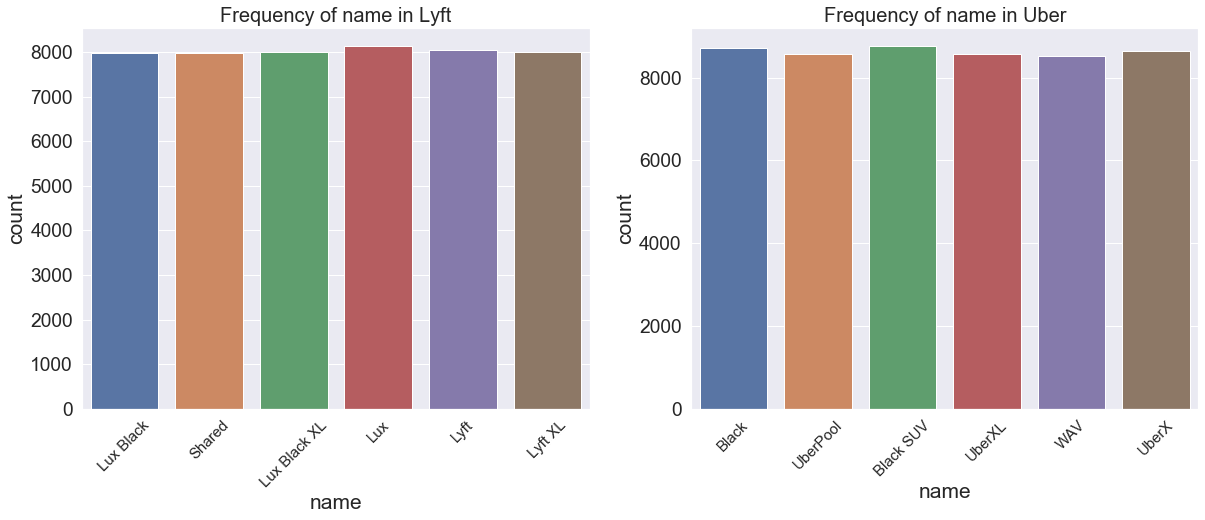

In [255]:
cab_data.loc[:,['destination','source','name']].apply(EDA_cat_function,axis=0)

## Price Vs Distance Analysis

(0, 100)

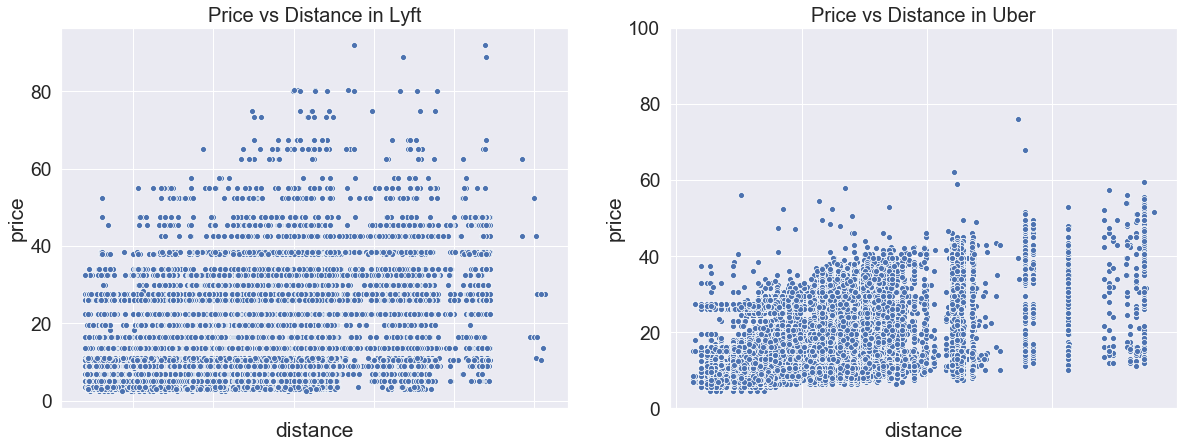

In [256]:
# scatterplot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 7))
sns.scatterplot(lyft['distance'], lyft['price'], ax=ax1)
ax1.set_title('Price vs Distance in Lyft', fontsize=20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=15)
sns.scatterplot(uber['distance'], uber['price'], ax=ax2)
ax2.set_title('Price vs Distance in Uber', fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=15)
ax2.set_ylim(0, 100)

In [257]:
lyft['distance'].corr(lyft['price'])

0.367633653363266

In [258]:
uber['distance'].corr(uber['price'])

0.34333065328904616

Distance is one of the important factors, which drives the price of the rides.  We could see that there is a positive 
correlation in the graph, with the presence of outliers as we saw before, because of the use of luxury car models and 
bad weather conditions.

### Data Tables  - Get better sense of the data

**Cab type vs Surge multiplier**

In [259]:
pd.crosstab(cab_data['cab_type'], cab_data['surge_multiplier'])

surge_multiplier,1.0,1.25,1.5,1.75,2.0,2.5,3.0
cab_type,,,,,,,
Lyft,44858,1715,810,372,352,25,1
Uber,51802,0,0,0,0,0,0


We observe that surge multiplier is not available for uber data and only present in Lyft data.

**Car model vs Surge multiplier**

In [260]:
pd.crosstab(lyft['name'], lyft['surge_multiplier'])

surge_multiplier,1.0,1.25,1.5,1.75,2.0,2.5,3.0
name,,,,,,,
Lux,7481,346,150,71,79,0,0
Lux Black,7315,343,157,94,64,0,0
Lux Black XL,7343,350,162,70,83,0,0
Lyft,7372,353,173,64,61,10,0
Lyft XL,7365,323,168,73,65,15,1
Shared,7982,0,0,0,0,0,0
